In [250]:
import pandas as pd
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
import holidays
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def create_Pipeline(num_columns, VAR_num_scaler, le_columns, oh_columns, VAR_regressor):
    le_transformer = FunctionTransformer(
        lambda x: np.array(pd.factorize(x.squeeze())[0]).reshape(-1, 1)
    )
    preprocessor = ColumnTransformer(transformers=[
        ('scaled_num', VAR_num_scaler, num_columns),        # Scaling for numerical columns
        ('le_encoded', le_transformer, le_columns),         # Label encoding for specific columns
        ('oh_encoded', OneHotEncoder(), oh_columns)         # One-hot encoding for categorical columns
    ])
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', VAR_regressor)
    ])
    return pipeline


def fine_tune(pipeline, data, target):
    param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 7],
        #'regressor__min_samples_split': [2, 5],
        #'regressor__min_samples_leaf': [1, 2],
        #'regressor__max_features': ['sqrt', 'log2', None],
        #'regressor__bootstrap': [True, False]
    }
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search_result = grid_search.fit(data, target, error_score='raise')
    return grid_search_result


def final_output(grid_search_result, test_data):
    y_pred = grid_search_result.predict(test_data)
    results = pd.DataFrame(
        dict(
            Id = np.arange(y_pred.shape[0]),
            log_bike_count=y_pred,
        )
    )
    results.to_csv(f'submission_{grid_search_result}.csv', index=False)

def clean(df, df_name):
    df = df.dropna()
    return df




In [251]:
data = pd.read_parquet(Path('data') / 'train.parquet')
data_meteo = pd.read_csv('external_data/export-paris0.csv')
data_test = pd.read_parquet(Path('data') / 'final_test.parquet')


## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [252]:
def _encode_dates_data(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X['isWeekend'] = X['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    vacances = holidays.CountryHoliday('France', years=[i for i in range(2009, 2025)])
    vacances_dates = pd.to_datetime(list(vacances.keys())).date
    X['isHoliday'] = X["date"].isin(vacances_dates).astype(int)

    return X

In [253]:
def _encode_dates_data_meteo(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["DATE"] = pd.to_datetime(X["DATE"])
    X["year"] = X["DATE"].dt.year
    X["month"] = X["DATE"].dt.month
    X["day"] = X["DATE"].dt.day
    X = X.drop(columns = ['TEMPERATURE_NIGHT_C', 'SUNRISE', 'SUNSET'] )



    # Finally we can drop the original columns from the dataframe
    return X

In [254]:
_encode_dates_data_meteo(data_meteo)

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,...,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION,year,month,day
0,2009-01-01,4,-2,9,-2,4,-2,0.0,96,7.000,...,143,113,116,0.0,1,8.6,météo très défavorable,2009,1,1
1,2009-01-02,1,-4,17,-4,1,-2,0.0,84,10.000,...,113,113,113,0.0,2,8.6,météo très défavorable,2009,1,2
2,2009-01-03,1,-3,17,-3,1,-2,0.0,96,10.000,...,116,113,113,0.0,2,8.6,météo très défavorable,2009,1,3
3,2009-01-04,-1,-5,6,-5,-1,-4,0.0,69,10.000,...,113,116,113,0.0,2,6.9,météo très défavorable,2009,1,4
4,2009-01-05,-1,-3,10,-3,-1,-2,5.5,95,6.125,...,119,122,338,4.7,2,3.2,météo très défavorable,2009,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5808,2024-11-26,11,7,15,7,10,9,0.0,75,10.000,...,113,113,122,0.0,3,8.0,météo défavorable,2024,11,26
5809,2024-11-27,13,10,29,10,12,11,1.1,83,9.875,...,176,176,296,0.0,3,1.0,météo défavorable,2024,11,27
5810,2024-11-28,9,7,9,7,8,6,0.1,75,10.000,...,116,113,113,0.0,2,6.0,météo défavorable,2024,11,28
5811,2024-11-29,8,3,15,3,7,6,0.0,80,10.000,...,113,113,119,0.0,3,8.0,météo très défavorable,2024,11,29


In [255]:
def compile_data(raw_bike_counter_data, raw_data_meteo):

    bike_counter_data = raw_bike_counter_data.copy()
    data_meteo = raw_data_meteo.copy()

    bike_counter_data = clean(bike_counter_data, 'bike_counter_data')
    bike_counter_data = _encode_dates_data(bike_counter_data)

    data_meteo['DATE'] = pd.to_datetime(data_meteo['DATE'])
    data_meteo = _encode_dates_data_meteo(data_meteo)
    data_meteo = clean(data_meteo, 'data_meteo')

    merged_data = pd.merge(bike_counter_data, data_meteo, on=['year', 'month', 'day'])

    return merged_data


In [256]:
data = compile_data(data, data_meteo)
data_test = compile_data(data_test, data_meteo)


## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [257]:
problem_title = "Bike count prediction"
_target_column_name = "log_bike_count"

def get_train_data():
    df = data.copy()
    df = df.sort_values(["date", "counter_name"])
    y_array = df[_target_column_name].values
    X_df = df.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [258]:
print(data.columns)
X, y = get_train_data()
X.head(2)

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count',
       'year', 'month', 'day', 'weekday', 'hour', 'isWeekend', 'isHoliday',
       'DATE', 'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'WEATHER_CODE_MORNING',
       'WEATHER_CODE_NOON', 'WEATHER_CODE_EVENING', 'TOTAL_SNOW_MM',
       'UV_INDEX', 'SUNHOUR', 'OPINION'],
      dtype='object')


,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION
443,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,19,9,15,116,116,116,0.0,5,9.1,météo favorable
460,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,19,9,15,116,116,116,0.0,5,9.1,météo favorable


and

In [259]:
y

array([1.60943791, 1.38629436, 0.        , ..., 3.49650756, 2.30258509,
       2.07944154])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [260]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [261]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

X_train

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION
443,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,19,9,15,116,116,116,0.0,5,9.1,météo favorable
460,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,19,9,15,116,116,116,0.0,5,9.1,météo favorable
103,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,19,9,15,116,116,116,0.0,5,9.1,météo favorable
130,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,19,9,15,116,116,116,0.0,5,9.1,météo favorable
1203,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,...,19,9,15,116,116,116,0.0,5,9.1,météo favorable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456266,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,2021-08-10 23:00:00,2020-02-18,"48.84201,2.36729",YTH19111508,48.842010,2.367290,...,25,14,17,116,116,122,0.0,5,12.4,météo correcte
456290,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2021-08-10 23:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,...,25,14,17,116,116,122,0.0,5,12.4,météo correcte
456308,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-08-10 23:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,...,25,14,17,116,116,122,0.0,5,12.4,météo correcte
455330,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,2021-08-10 23:00:00,2017-12-15,"48.8484,2.27586",Y2H21025335,48.848400,2.275860,...,25,14,17,116,116,122,0.0,5,12.4,météo correcte


In [276]:
_encode_dates_data(X_train).columns.tolist()
_encode_dates_data(X_train[["date"]]).drop(columns = ["date"]).columns.tolist()
_encode_dates_data(X_train).drop(columns = ["date"]).columns.tolist()

['counter_id',
 'counter_name',
 'site_id',
 'site_name',
 'counter_installation_date',
 'coordinates',
 'counter_technical_id',
 'latitude',
 'longitude',
 'year',
 'month',
 'day',
 'weekday',
 'hour',
 'isWeekend',
 'isHoliday',
 'DATE',
 'MAX_TEMPERATURE_C',
 'MIN_TEMPERATURE_C',
 'WINDSPEED_MAX_KMH',
 'TEMPERATURE_MORNING_C',
 'TEMPERATURE_NOON_C',
 'TEMPERATURE_EVENING_C',
 'PRECIP_TOTAL_DAY_MM',
 'HUMIDITY_MAX_PERCENT',
 'VISIBILITY_AVG_KM',
 'PRESSURE_MAX_MB',
 'CLOUDCOVER_AVG_PERCENT',
 'HEATINDEX_MAX_C',
 'DEWPOINT_MAX_C',
 'WINDTEMP_MAX_C',
 'WEATHER_CODE_MORNING',
 'WEATHER_CODE_NOON',
 'WEATHER_CODE_EVENING',
 'TOTAL_SNOW_MM',
 'UV_INDEX',
 'SUNHOUR',
 'OPINION']

In [277]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

date_encoder = FunctionTransformer(_encode_dates_data)
date_cols = _encode_dates_data(X_train[["date"]]).drop(columns = ["date"]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = _encode_dates_data(X_train).drop(columns = ["date"]).columns.tolist()
print(categorical_cols)
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

param_grid_ridge = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0],   # Regularization strength
    #'ridge__solver': ['auto', 'svd', 'cholesky', 'saga'],  # Solver types for Ridge
    'ridge__tol': [1e-4, 1e-3, 1e-2, 1e-1],  # Tolerance for stopping criteria
    #'ridge__max_iter': [1000, 2000, 3000]   # Maximum number of iterations
}

pipe = make_pipeline(date_encoder, preprocessor, regressor)

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_ridge,
    cv=5,                               # 5-Fold cross-validation
    n_jobs=-1,                          # Use all available CPUs
    scoring='neg_mean_squared_error',   # Use negative MSE for regression
    verbose=1
)


grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_


['counter_id', 'counter_name', 'site_id', 'site_name', 'counter_installation_date', 'coordinates', 'counter_technical_id', 'latitude', 'longitude', 'year', 'month', 'day', 'weekday', 'hour', 'isWeekend', 'isHoliday', 'DATE', 'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH', 'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C', 'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM', 'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C', 'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'WEATHER_CODE_MORNING', 'WEATHER_CODE_NOON', 'WEATHER_CODE_EVENING', 'TOTAL_SNOW_MM', 'UV_INDEX', 'SUNHOUR', 'OPINION']
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [278]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(model.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

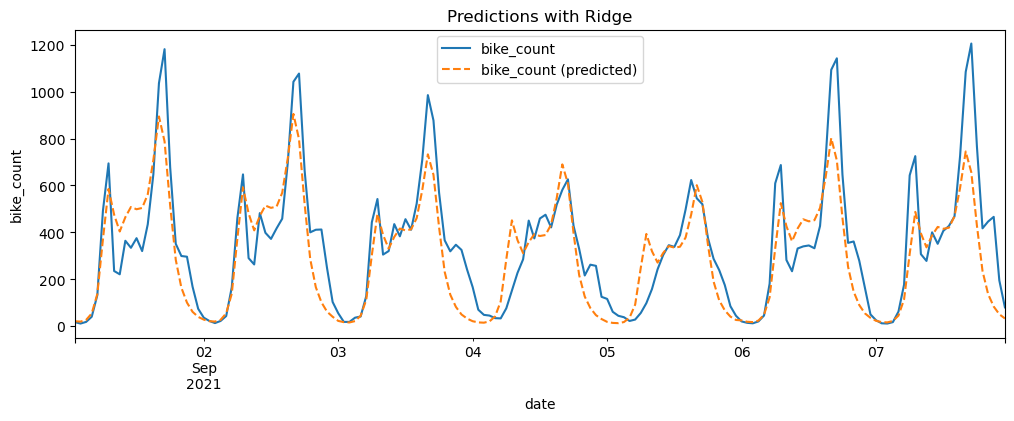

In [279]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

In [280]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.93808901 -0.90676405 -0.83191077 -0.85519482 -1.02166764 -0.92535021]
RMSE (all folds): 0.913 ± 0.0613


# Final test

In [281]:
def final_output(model, test_data):
    y_pred = model.predict(test_data)
    results = pd.DataFrame(
        dict(
            Id = np.arange(y_pred.shape[0]),
            log_bike_count=y_pred,
        )
    )
    results.to_csv(f'submission.csv', index=False)

In [282]:
final_output(model, data_test)